In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from json_data_getter import get_all_json

# Data preparation

## Loading

In [3]:
# gets all the json files toghether, may take a minute
number_documents, keys, documents = get_all_json()
df = pd.DataFrame.from_dict(documents)

## Cleaning

In [4]:
# keep NaN for float columns, empty strings for string columns
for col in df:
    # get dtype for column
    dt = df[col].dtype
    # check if it is a number
    if dt == int or dt == float:
        pass
    else:
        df[col].fillna("", inplace=True)

# set dates to datetime type
df['publicationDate'] = pd.to_datetime(
    df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

In [5]:
df.columns

Index(['alternativeExcerpt', 'alternativeTitle', 'articleURL', 'backgrounds',
       'contributors', 'durationSec', 'excerpt', 'genres', 'id', 'imageURL',
       'isOnline', 'mediaType', 'mediaURL', 'program',
       'publicationChannelNames', 'publicationDate', 'source',
       'thematicCorporations', 'thematicGeographicals', 'thematicPersons',
       'thematicThemes', 'title', 'variantIds', 'visualCorporations',
       'visualGeographicals', 'visualPersons', 'visualThemes'],
      dtype='object')

## distribution in time

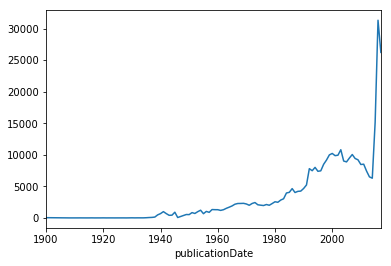

In [6]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()
doc_per_year.plot()
plt.show()

## Programs lifespan

In [7]:
def get_program_lifespan(df):
    program_groups = df.groupby(df.program)
    df_lifespan = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_lifespan['lifespan_days'] = (
        df_lifespan['max'] - df_lifespan['min']).astype('timedelta64[D]')
    return df_lifespan

In [8]:
get_program_lifespan(df).sort_values('lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1900-01-01 00:00:00,2017-11-15 00:00:00,20458,43052.0
TJ midi,1900-01-01 19:00:00,2011-12-04 11:45:00,204,40878.0
Marabout de ficelle,1900-01-01 00:00:00,1998-05-20 00:00:00,148,35933.0
Mémoires de la musique,1922-06-05 00:00:00,2004-01-23 00:00:00,2086,29817.0
Archives,1939-11-30 02:00:00,2017-10-03 13:10:37,120,28432.0


The first row is the group of unnamed programs. Some duration seem a bit too long, maybe there are errors in the dates. Let's take TJ midi and check the distribution of transmissions by year.

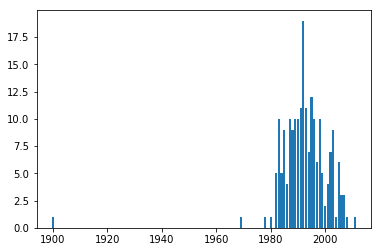

In [9]:
program_groups = df.groupby(df.program)

TJmidi = program_groups.get_group('TJ midi')

TJmidi_date_distribution = TJmidi.groupby(
    TJmidi.publicationDate.map(lambda x: (x.year))).size()

plt.bar(TJmidi_date_distribution.index, TJmidi_date_distribution.values)

plt.show()

There are some obvious outliers, let's remove them.

### Date outliers removal

In [10]:
# remove date outliers
def remove_date_outliers(df):
    CONSTANT_STD = 2
    df_without_date_outliers = df.copy()

    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)

    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(
        ["mean", 'std'])

    temp_df = pd.merge(
        df,
        mean_std_year_per_program,
        how='left',
        left_on=['program'],
        right_index=True)

    df_without_date_outliers.loc[
        (np.abs(temp_df.publicationDateYear - temp_df['mean']) >
         CONSTANT_STD * temp_df['std']), 'publicationDate'] = pd.NaT

    return df_without_date_outliers

In [11]:
df_without_date_outliers = remove_date_outliers(df)
get_program_lifespan(df_without_date_outliers).sort_values(
    'lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1921-11-23,2017-11-15 00:00:00,20458,35056.0
Documentaire,1952-11-30,2017-11-11 14:00:00,740,23722.0
Cyclisme,1953-11-30,2017-08-19 00:00:00,138,23273.0
Motocyclisme,1954-06-09,2017-08-13 00:00:00,14,23076.0
Souvenirs de vedette,1949-03-31,2009-12-17 00:00:00,4,22176.0


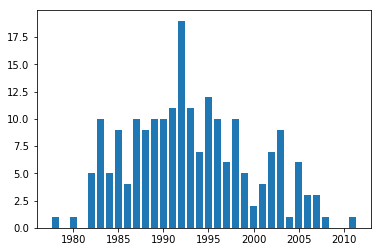

In [12]:
program_groups_without_outliers = df_without_date_outliers.groupby(df.program)

TJmidi = program_groups_without_outliers.get_group('TJ midi')

TJmidi_date_distribution = TJmidi.groupby(
    TJmidi.publicationDate.map(lambda x: (x.year))).size()

plt.bar(TJmidi_date_distribution.index, TJmidi_date_distribution.values)

plt.show()

# Gender (Sina)

# Location (Mohammed)

# Factors for program lifespan (Leo)

In [45]:
from collections import Counter
Counter(flat_list).most_common(10)

[('GUERRE MONDIALE (DEUXIÈME)', 51),
 ('VILLE', 48),
 ('PORTRAIT', 39),
 ('ANNÉES 1960', 36),
 ('TOURISME', 32),
 ('SCÈNE DE RUE', 31),
 ('RÉFUGIÉ', 29),
 ('PORT', 20),
 ('CHÂTEAU', 18),
 ('ANNÉES 1950', 18)]

In [38]:
genra = program_groups_without_outliers.get_group(
    'Documentaire').visualThemes.values


flat_list = [item for sublist in genra for item in sublist]
flat_list
unique, counts = np.unique(flat_list, return_counts=True)

di = [{u:c} for u,c in zip(unique, counts)]
#print(unique)
#print(counts)
di

[{'19E SIÈCLE': 2},
 {'ABBAYE': 7},
 {"ABORIGÈNES D'AUSTRALIE": 3},
 {'ABRI ANTIATOMIQUE': 8},
 {'ACCIDENT AÉRIEN': 2},
 {'ACCIDENT DE MONTAGNE': 3},
 {'ACCORD INTERNATIONAL': 1},
 {'ACCOUCHEMENT': 1},
 {'ACIER': 1},
 {'ACROBATIE (ART)': 2},
 {'ACROBATIE AÉRIENNE': 1},
 {'ADOLESCENT': 12},
 {'ADOPTION': 1},
 {'AGRICULTURE': 5},
 {'AGRICULTURE DE MONTAGNE': 1},
 {'AID EL-ADHA': 1},
 {'AIDE ALIMENTAIRE': 1},
 {'AIDE AU DÉVELOPPEMENT': 2},
 {'AIDE HUMANITAIRE': 3},
 {'AIDE MÉDICALE INTERNATIONALE': 1},
 {'ALCOOL (ALIMENTAIRE)': 2},
 {'ALCOOLISME': 3},
 {'ALCOOLISME AU VOLANT': 3},
 {'ALPAGE': 2},
 {'ALPINISME': 7},
 {'ALTERMONDIALISME': 1},
 {'AMOUR': 1},
 {'AMÉNAGEMENT DU TERRITOIRE': 1},
 {'AMÉNAGEMENT URBAIN': 2},
 {'AMÉRINDIENS': 13},
 {'ANALYSE CHIMIQUE': 1},
 {'ANARCHISME': 2},
 {'ANIMAL EN PELUCHE': 1},
 {'ANIMAL SAUVAGE': 2},
 {'ANIMATION': 6},
 {'ANIMISME': 2},
 {'ANNÉES 1930': 2},
 {'ANNÉES 1940': 2},
 {'ANNÉES 1950': 18},
 {'ANNÉES 1960': 36},
 {'ANNÉES 1970': 16},
 {'ANNÉES 19

## data preparation

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

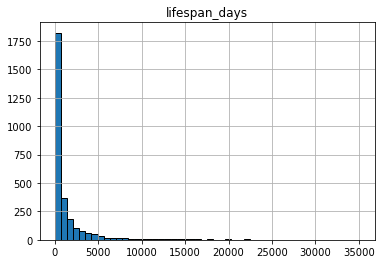

In [14]:
lifespan = get_program_lifespan(df_without_date_outliers)
lifespan['lifespan_class'] = (pd.qcut(
    lifespan.lifespan_days, 2, labels=[0, 1]))
lifespan.hist(column='lifespan_days', bins=50, ec='black')
plt.show()

In [15]:
def generate_data_for_factor(factor):
    factor_per_program = pd.DataFrame()
    factor_per_program[factor] = df_without_date_outliers[factor].apply(
        lambda x: ' '.join(x))
    factor_per_program['program'] = df_without_date_outliers.program
    factors = factor_per_program.groupby(
        factor_per_program.program).agg(lambda x: ' '.join(x))
    evaluate_df = lifespan.merge(factors, left_index=True, right_index=True)
    # drop programs with no name
    evaluate_df = evaluate_df.drop('')
    X = evaluate_df[factor]
    y = evaluate_df.lifespan_class
    return X, y

In [16]:
# classifiers for model selection
count_vect = CountVectorizer(ngram_range=(1, 2), max_df=0.5)
tfidf_transformer = TfidfTransformer()

classifiers = [
    SGDClassifier(alpha=1e-5, random_state=42),
    svm.SVC(),
    RandomForestClassifier(max_depth=5, n_estimators=10)
]

classifiers_name = ['SGDClassifier', 'svc', 'randomforest']

## thematicThemes

In [17]:
X, y = generate_data_for_factor('thematicThemes')

### model selection

In [18]:
X_count = count_vect.fit_transform(X)
X_tfidf = tfidf_transformer.fit_transform(X_count)

In [95]:
for i, classifier in zip(classifiers_name, classifiers):
    scores = cross_val_score(classifier, X_tfidf, y, cv=5)
    print('for {}'.format(i))
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

for SGDClassifier
Accuracy: 0.637 (+/- 0.025)
for svc
Accuracy: 0.501 (+/- 0.001)
for randomforest
Accuracy: 0.654 (+/- 0.041)


### Grid search for random forest

In [99]:
clf = RandomForestClassifier(
    #max_depth=50,
    random_state=42,
    min_samples_leaf=40,
    n_estimators=16,
    max_features='auto')

pipeline = Pipeline([
    ('vect', count_vect),
    ('tfidf', tfidf_transformer),
    ('clf', clf),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    #'clf__max_depth': np.arange(30, 51, 10),
    'clf__n_estimators': np.power(2, np.arange(1, 6, 1)),
    'clf__min_samples_leaf' : np.arange(40,61,5),
}

In [100]:
gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=10, cv=3)

In [101]:
gs_clf = gs_clf.fit(X, y)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Paralle

In [19]:
gs_clf.best_score_

NameError: name 'gs_clf' is not defined

In [103]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__min_samples_leaf: 40
clf__n_estimators: 16
vect__max_df: 0.5
vect__ngram_range: (1, 2)


#### with only 2 labels

In [20]:
(X_tfidf.getrow(2))

<1x166098 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [21]:
RFC = RandomForestClassifier( min_samples_leaf=40, n_estimators=16)
RFC.fit(X_tfidf, y)
feat_imp = RFC.feature_importances_

In [34]:
importances = feat_imp
std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

In [35]:
indices

array([122493,  61949,  39042,  10832, 131960, 104051,  96238, 126951,
         7147,  85574, 140933,   8748, 104040,  21959, 124283,  82587,
       163445,  41442,  24843,  38039], dtype=int64)

Feature ranking:
1. feature 122493 (0.074567)
2. feature 61949 (0.062500)
3. feature 39042 (0.062500)
4. feature 10832 (0.059545)
5. feature 131960 (0.038355)
6. feature 104051 (0.037772)
7. feature 96238 (0.037566)
8. feature 126951 (0.031323)
9. feature 7147 (0.031177)
10. feature 85574 (0.028217)
11. feature 140933 (0.024414)
12. feature 8748 (0.024145)
13. feature 104040 (0.021919)
14. feature 21959 (0.021275)
15. feature 124283 (0.019440)
16. feature 82587 (0.019201)
17. feature 163445 (0.019183)
18. feature 41442 (0.014295)
19. feature 24843 (0.011348)
20. feature 38039 (0.010639)


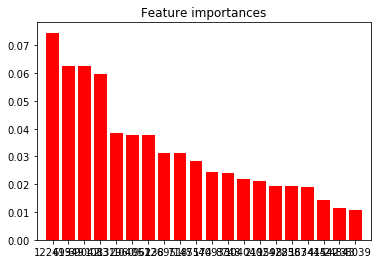

In [36]:
# Print the feature ranking
range_ = range(len(indices))

print("Feature ranking:")

for f in range_:
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(
    range_,
    importances[indices],
    color="r",
    #yerr=std[indices],
    align="center")
plt.xticks(range_, indices)
plt.xlim([-1, len(indices)])
plt.show()

## Visual theme

## Thematic theme

## Location theme